# Improved Model: XGBoost
## Cardiovascular Disease Prediction Project

**Author:** Eva Hallermeier  
**Model:** XGBoost (Improved Model)  
**Goal:** Improve upon Logistic Regression baseline through ensemble learning

**Baseline Performance (Logistic Regression):**
- AUC-ROC: 0.7922
- Recall: 66.9% (at threshold 0.5) / 84.1% (at optimal 0.37)
- F1-Score: 0.7083 (at 0.5) / 0.7342 (at optimal 0.37)

**XGBoost Goals:**
- Target AUC-ROC: > 0.80 (improvement of 0.01+)
- Capture non-linear feature interactions
- Improve recall without sacrificing precision
- Resolve counterintuitive feature effects (e.g., smoking)

**This notebook covers:**
1. Loading preprocessed data
2. XGBoost hyperparameter tuning (RandomizedSearchCV)
3. Model training with early stopping
4. Model evaluation and comparison with baseline
5. Feature importance analysis (gain, cover, weight)
6. SHAP values for interpretability
7. Threshold optimization
8. Model comparison and final recommendation

---

## 1. Setup and Load Data

In [73]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import pickle
import warnings
import json
import time
from scipy.stats import uniform, randint

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"Random seed: {RANDOM_STATE}")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
Random seed: 42
XGBoost version: 3.1.3


In [74]:
# Load preprocessed data
print("Loading Preprocessed Data:")
print("=" * 80)

X_train = pd.read_csv('/content/processed_data/X_train.csv')
X_test = pd.read_csv('/content/processed_data/X_test.csv')
y_train = pd.read_csv('/content/processed_data/y_train.csv').values.ravel()
y_test = pd.read_csv('/content/processed_data/y_test.csv').values.ravel()

print(f"✓ Training data: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"✓ Test data: X_test {X_test.shape}, y_test {y_test.shape}")

# Load baseline results for comparison
with open('models/logistic_regression_results.json', 'r') as f:
    baseline_results = json.load(f)

print(f"\n✓ Baseline (Logistic Regression) results loaded")
print(f"  Baseline AUC-ROC: {baseline_results['test_metrics']['auc_roc']:.4f}")
print(f"  Baseline Recall: {baseline_results['test_metrics']['recall']:.4f}")
print(f"  Baseline F1: {baseline_results['test_metrics']['f1_score']:.4f}")

Loading Preprocessed Data:
✓ Training data: X_train (51482, 16), y_train (51482,)
✓ Test data: X_test (17161, 16), y_test (17161,)

✓ Baseline (Logistic Regression) results loaded
  Baseline AUC-ROC: 0.7922
  Baseline Recall: 0.6686
  Baseline F1: 0.7083


### 🔍 Interpretation - Starting Point:

**Baseline to Beat:**
- Logistic Regression AUC: 0.7922
- Target for XGBoost: > 0.80 (meaningful improvement)

**Why XGBoost Should Perform Better:**
1. **Captures Non-Linear Relationships**: Age × BP interactions, BMI × Cholesterol
2. **Handles Feature Interactions**: Automatic interaction detection
3. **Robust to Outliers**: Tree-based splitting handles extreme values
4. **Feature Importance**: Multiple metrics (gain, cover, weight)

**Expected Improvements:**
- AUC increase: +0.01 to +0.03
- Better recall at same precision
- Corrected feature effects (smoking should show risk, not protection)

## 2. XGBoost Model Overview

### Why XGBoost as Improved Model?

**XGBoost (eXtreme Gradient Boosting) Advantages:**

1. **Ensemble Learning**: Combines many weak decision trees into strong predictor
2. **Gradient Boosting**: Sequentially corrects previous trees' errors
3. **Regularization**: L1 (Lasso) and L2 (Ridge) prevent overfitting
4. **Handles Non-Linearity**: Captures complex age-disease relationships
5. **Feature Interactions**: Automatically discovers BP × Age, BMI × Cholesterol effects
6. **Missing Data**: Built-in handling (though we have none)
7. **Parallel Processing**: Fast training on large datasets

**Key Hyperparameters to Tune:**
- `n_estimators`: Number of boosting rounds (trees)
- `max_depth`: Tree depth (controls complexity)
- `learning_rate`: Step size shrinkage (prevents overfitting)
- `subsample`: Fraction of samples per tree (prevents overfitting)
- `colsample_bytree`: Fraction of features per tree (prevents overfitting)
- `min_child_weight`: Minimum samples per leaf (regularization)
- `gamma`: Minimum loss reduction for split (regularization)

**Strategy:**
Use RandomizedSearchCV (not GridSearchCV) because:
- XGBoost has many hyperparameters → grid search too slow
- Random search explores parameter space efficiently
- Can test 50+ combinations in reasonable time

## 3. Hyperparameter Tuning with RandomizedSearchCV

In [75]:
# Define comprehensive hyperparameter space
print("XGBoost Hyperparameter Tuning Setup:")
print("=" * 80)

param_distributions = {
    'n_estimators': randint(100, 500),           # Number of trees
    'max_depth': randint(3, 10),                 # Tree depth
    'learning_rate': uniform(0.01, 0.29),        # Step size: 0.01 to 0.3
    'subsample': uniform(0.6, 0.4),              # Sample fraction: 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),       # Feature fraction: 0.6 to 1.0
    'min_child_weight': randint(1, 10),          # Min samples per leaf
    'gamma': uniform(0, 0.5),                    # Min loss reduction
    'reg_alpha': uniform(0, 1),                  # L1 regularization
    'reg_lambda': uniform(0, 2)                  # L2 regularization
}

print("\nHyperparameter Search Space:")
for param, distribution in param_distributions.items():
    print(f"  {param:20} : {distribution}")

print(f"\nSearch Strategy: RandomizedSearchCV")
print(f"  Number of iterations: 50")
print(f"  Cross-validation folds: 3 (faster than 5 for large dataset)")
print(f"  Total model fits: 50 × 3 = 150")
print(f"  Scoring metric: roc_auc")
print(f"  Estimated time: 10-15 minutes")

XGBoost Hyperparameter Tuning Setup:

Hyperparameter Search Space:
  n_estimators         : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7daa0d7b26c0>
  max_depth            : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7daa2abbe0c0>
  learning_rate        : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7daa0d7cffb0>
  subsample            : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7daa1d429be0>
  colsample_bytree     : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7daa0d798e60>
  min_child_weight     : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7daa0d7cf500>
  gamma                : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7daa1c1b0920>
  reg_alpha            : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7daa0d6ba210>
  reg_lambda           : <scipy.stats._distn_infrastructure.rv_continuous_frozen ob

In [76]:
# Initialize base XGBoost model
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method='hist'  # Faster for large datasets
)

print("Base XGBoost Model Configuration:")
print("=" * 80)
print(f"  Objective: binary:logistic (binary classification)")
print(f"  Eval metric: AUC (area under ROC curve)")
print(f"  Random state: {RANDOM_STATE}")
print(f"  Parallel jobs: -1 (all CPU cores)")
print(f"  Tree method: hist (optimized for large data)")
print("\n✓ Base model initialized")

Base XGBoost Model Configuration:
  Objective: binary:logistic (binary classification)
  Eval metric: AUC (area under ROC curve)
  Random state: 42
  Parallel jobs: -1 (all CPU cores)
  Tree method: hist (optimized for large data)

✓ Base model initialized


In [77]:
# Initialize RandomizedSearchCV
print("\nInitializing RandomizedSearchCV:")
print("=" * 80)

xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=50,           # Test 50 random combinations
    cv=3,                # 3-fold CV (faster than 5)
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

print("✓ RandomizedSearchCV configured")
print(f"  Estimator: XGBClassifier")
print(f"  CV strategy: 3-fold")
print(f"  Random iterations: 50")
print(f"  Scoring: roc_auc")
print(f"  Parallel jobs: -1 (all cores)")


Initializing RandomizedSearchCV:
✓ RandomizedSearchCV configured
  Estimator: XGBClassifier
  CV strategy: 3-fold
  Random iterations: 50
  Scoring: roc_auc
  Parallel jobs: -1 (all cores)


In [78]:
# Train with hyperparameter tuning
print("\nStarting Hyperparameter Tuning...")
print("=" * 80)
print("⏱️  This will take approximately 10-15 minutes...")
print("☕ Time for a coffee break!\n")

start_time = time.time()

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\n{'='*80}")
print(f"✓ Hyperparameter tuning complete!")
print(f"  Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Starting Hyperparameter Tuning...
⏱️  This will take approximately 10-15 minutes...
☕ Time for a coffee break!

Fitting 3 folds for each of 50 candidates, totalling 150 fits

✓ Hyperparameter tuning complete!
  Total training time: 216.51 seconds (3.61 minutes)


In [79]:
# Extract best model and parameters
best_xgb = xgb_random.best_estimator_
best_params_xgb = xgb_random.best_params_
best_score_xgb = xgb_random.best_score_

print("\nBest Model Results:")
print("=" * 80)
print(f"\nBest Parameters:")
for param, value in sorted(best_params_xgb.items()):
    print(f"  {param:20} : {value:.4f}" if isinstance(value, float) else f"  {param:20} : {value}")

print(f"\nBest Cross-Validation Score:")
print(f"  AUC-ROC (CV): {best_score_xgb:.4f}")

# Compare with baseline
baseline_cv_auc = baseline_results['cv_auc_roc']
cv_improvement = best_score_xgb - baseline_cv_auc

print(f"\nComparison with Baseline (Logistic Regression):")
print(f"  Baseline CV AUC:  {baseline_cv_auc:.4f}")
print(f"  XGBoost CV AUC:   {best_score_xgb:.4f}")
print(f"  Improvement:      {cv_improvement:+.4f} ({cv_improvement/baseline_cv_auc*100:+.2f}%)")

if cv_improvement > 0.01:
    print("\n  ✓ Meaningful improvement achieved (>0.01 AUC gain)")
elif cv_improvement > 0:
    print("\n  ⚠ Modest improvement - models perform similarly")
else:
    print("\n  ⚠ No improvement - baseline may be optimal")


Best Model Results:

Best Parameters:
  colsample_bytree     : 0.8364
  gamma                : 0.3388
  learning_rate        : 0.0148
  max_depth            : 5
  min_child_weight     : 3
  n_estimators         : 247
  reg_alpha            : 0.6452
  reg_lambda           : 0.3487
  subsample            : 0.8764

Best Cross-Validation Score:
  AUC-ROC (CV): 0.8015

Comparison with Baseline (Logistic Regression):
  Baseline CV AUC:  0.7915
  XGBoost CV AUC:   0.8015
  Improvement:      +0.0100 (+1.27%)

  ✓ Meaningful improvement achieved (>0.01 AUC gain)


In [80]:
# Analyze hyperparameter search results
cv_results_xgb = pd.DataFrame(xgb_random.cv_results_)

print("\nHyperparameter Search Analysis:")
print("=" * 80)

# Top 5 parameter combinations
results_summary = cv_results_xgb[[
    'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score'
]].copy()
results_summary.columns = ['CV_AUC_Mean', 'CV_AUC_Std', 'Train_AUC', 'Rank']
results_summary = results_summary.sort_values('Rank').head(5)

print("\nTop 5 Parameter Combinations:")
print(results_summary.to_string(index=False))

# Overfitting analysis
best_idx = xgb_random.best_index_
train_test_gap_xgb = cv_results_xgb.loc[best_idx, 'mean_train_score'] - cv_results_xgb.loc[best_idx, 'mean_test_score']

print(f"\nOverfitting Analysis (Best Model):")
print(f"  Training AUC:   {cv_results_xgb.loc[best_idx, 'mean_train_score']:.4f}")
print(f"  Validation AUC: {cv_results_xgb.loc[best_idx, 'mean_test_score']:.4f}")
print(f"  Gap:            {train_test_gap_xgb:.4f}")

if train_test_gap_xgb < 0.05:
    print("  ✓ Low overfitting - excellent generalization")
elif train_test_gap_xgb < 0.10:
    print("  ⚠ Moderate overfitting - acceptable")
else:
    print("  ✗ High overfitting - consider stronger regularization")


Hyperparameter Search Analysis:

Top 5 Parameter Combinations:
 CV_AUC_Mean  CV_AUC_Std  Train_AUC  Rank
      0.8015      0.0014     0.8127     1
      0.8009      0.0015     0.8055     2
      0.8007      0.0016     0.8062     3
      0.8006      0.0016     0.8213     4
      0.8004      0.0015     0.8139     5

Overfitting Analysis (Best Model):
  Training AUC:   0.8127
  Validation AUC: 0.8015
  Gap:            0.0111
  ✓ Low overfitting - excellent generalization


### 🔍 Interpretation - Hyperparameter Tuning:

**RandomizedSearchCV Strategy:**
- Tested 50 random parameter combinations
- Each tested with 3-fold cross-validation
- Total: 150 model fits (much faster than exhaustive grid search)

**Optimal Parameters Found:**
- Will show specific values of learning_rate, max_depth, etc.
- These balance model complexity with generalization

**CV Performance:**
- Compare XGBoost CV AUC with Logistic Regression CV AUC
- Target: >0.01 improvement for meaningful gain
- Overfitting check: Train-validation gap should be <0.05

**For Report:**
> "XGBoost hyperparameter optimization via RandomizedSearchCV (50 iterations, 3-fold CV) identified optimal configuration achieving CV AUC-ROC of [value], representing [+X]% improvement over the Logistic Regression baseline."

## 4. Model Evaluation on Test Set

In [81]:
# Make predictions on test set
print("Making Predictions on Test Set:")
print("=" * 80)

y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

print(f"\n✓ Predictions generated")
print(f"  Hard predictions (0/1): {y_pred_xgb.shape}")
print(f"  Probability predictions: {y_pred_proba_xgb.shape}")
print(f"\nProbability range: [{y_pred_proba_xgb.min():.4f}, {y_pred_proba_xgb.max():.4f}]")
print(f"Mean probability: {y_pred_proba_xgb.mean():.4f}")

Making Predictions on Test Set:

✓ Predictions generated
  Hard predictions (0/1): (17161,)
  Probability predictions: (17161,)

Probability range: [0.0599, 0.8830]
Mean probability: 0.4955


In [82]:
# Calculate comprehensive metrics
print("\nCalculating Performance Metrics:")
print("=" * 80)

# AUC-ROC
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# Precision, Recall, F1
precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb, average='binary'
)

# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Average Precision (PR-AUC)
ap_xgb = average_precision_score(y_test, y_pred_proba_xgb)

# Brier Score
brier_xgb = brier_score_loss(y_test, y_pred_proba_xgb)

print("\n" + "="*80)
print("XGBOOST - TEST SET PERFORMANCE")
print("="*80)

print(f"\n📊 PRIMARY METRICS:")
print(f"  AUC-ROC:          {auc_xgb:.4f}")
print(f"  Accuracy:         {accuracy_xgb:.4f}")
print(f"  Precision:        {precision_xgb:.4f}")
print(f"  Recall:           {recall_xgb:.4f}")
print(f"  F1-Score:         {f1_xgb:.4f}")
print(f"  PR-AUC:           {ap_xgb:.4f}")
print(f"  Brier Score:      {brier_xgb:.4f}")

# Load baseline metrics
baseline_metrics = baseline_results['test_metrics']

print(f"\n" + "="*80)
print("COMPARISON WITH BASELINE (Logistic Regression)")
print("="*80)

print(f"\n{'Metric':<20} {'Baseline':<12} {'XGBoost':<12} {'Δ Change':<12}")
print("-"*80)

metrics_compare = {
    'AUC-ROC': (baseline_metrics['auc_roc'], auc_xgb),
    'Accuracy': (baseline_metrics['accuracy'], accuracy_xgb),
    'Precision': (baseline_metrics['precision'], precision_xgb),
    'Recall': (baseline_metrics['recall'], recall_xgb),
    'F1-Score': (baseline_metrics['f1_score'], f1_xgb),
    'Brier Score': (baseline_metrics['brier_score'], brier_xgb)
}

for metric_name, (baseline_val, xgb_val) in metrics_compare.items():
    delta = xgb_val - baseline_val
    # For Brier score, lower is better, so flip the sign
    if metric_name == 'Brier Score':
        delta = -delta

    symbol = '✓' if delta > 0 else '✗'
    print(f"{metric_name:<20} {baseline_val:<12.4f} {xgb_val:<12.4f} {delta:>+11.4f} {symbol}")

# Overall assessment
auc_improvement = auc_xgb - baseline_metrics['auc_roc']
print(f"\n" + "="*80)
print("OVERALL ASSESSMENT:")
print("="*80)

if auc_improvement >= 0.02:
    print(f"\n✓ STRONG IMPROVEMENT: XGBoost shows {auc_improvement:.4f} AUC gain")
    print("  XGBoost is clearly the better model for deployment.")
elif auc_improvement >= 0.01:
    print(f"\n✓ MEANINGFUL IMPROVEMENT: XGBoost shows {auc_improvement:.4f} AUC gain")
    print("  XGBoost provides modest but worthwhile improvement.")
elif auc_improvement > 0:
    print(f"\n⚠ MARGINAL IMPROVEMENT: XGBoost shows {auc_improvement:.4f} AUC gain")
    print("  Consider interpretability vs. slight performance gain.")
else:
    print(f"\n⚠ NO IMPROVEMENT: XGBoost shows {auc_improvement:.4f} AUC change")
    print("  Logistic Regression baseline may be optimal for this dataset.")


Calculating Performance Metrics:

XGBOOST - TEST SET PERFORMANCE

📊 PRIMARY METRICS:
  AUC-ROC:          0.8019
  Accuracy:         0.7344
  Precision:        0.7541
  Recall:           0.6873
  F1-Score:         0.7191
  PR-AUC:           0.7863
  Brier Score:      0.1806

COMPARISON WITH BASELINE (Logistic Regression)

Metric               Baseline     XGBoost      Δ Change    
--------------------------------------------------------------------------------
AUC-ROC              0.7922       0.8019           +0.0098 ✓
Accuracy             0.7275       0.7344           +0.0069 ✓
Precision            0.7530       0.7541           +0.0011 ✓
Recall               0.6686       0.6873           +0.0187 ✓
F1-Score             0.7083       0.7191           +0.0109 ✓
Brier Score          0.1868       0.1806           +0.0061 ✓

OVERALL ASSESSMENT:

⚠ MARGINAL IMPROVEMENT: XGBoost shows 0.0098 AUC gain
  Consider interpretability vs. slight performance gain.


In [83]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n" + "="*80)
print("CONFUSION MATRIX - XGBOOST")
print("="*80)
print()
print("                 Predicted")
print("                 No CVD    CVD")
print(f"Actual No CVD    {cm_xgb[0,0]:6d}  {cm_xgb[0,1]:6d}")
print(f"Actual CVD       {cm_xgb[1,0]:6d}  {cm_xgb[1,1]:6d}")

# Calculate rates
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)
sensitivity_xgb = tp_xgb / (tp_xgb + fn_xgb)

print(f"\n📈 DETAILED BREAKDOWN:")
print(f"  True Negatives (TN):   {tn_xgb:6d} (Correctly predicted No CVD)")
print(f"  False Positives (FP):  {fp_xgb:6d} (Incorrectly predicted CVD)")
print(f"  False Negatives (FN):  {fn_xgb:6d} (Missed CVD cases)")
print(f"  True Positives (TP):   {tp_xgb:6d} (Correctly predicted CVD)")

print(f"\n🎯 DERIVED METRICS:")
print(f"  Sensitivity (Recall):  {sensitivity_xgb:.4f}")
print(f"  Specificity:           {specificity_xgb:.4f}")

# Compare with baseline confusion matrix
baseline_cm = baseline_results['confusion_matrix']
fn_baseline = baseline_cm['false_negatives']
fn_improvement = fn_baseline - fn_xgb

print(f"\n📊 COMPARISON WITH BASELINE:")
print(f"  Baseline Missed Cases: {fn_baseline:,}")
print(f"  XGBoost Missed Cases:  {fn_xgb:,}")
print(f"  Improvement:           {fn_improvement:+,} fewer missed cases")

if fn_improvement > 0:
    print(f"  ✓ XGBoost catches {fn_improvement} more CVD cases!")
elif fn_improvement < 0:
    print(f"  ⚠ XGBoost misses {-fn_improvement} more CVD cases")
else:
    print(f"  = Same number of missed cases")


CONFUSION MATRIX - XGBOOST

                 Predicted
                 No CVD    CVD
Actual No CVD      6768    1903
Actual CVD         2655    5835

📈 DETAILED BREAKDOWN:
  True Negatives (TN):     6768 (Correctly predicted No CVD)
  False Positives (FP):    1903 (Incorrectly predicted CVD)
  False Negatives (FN):    2655 (Missed CVD cases)
  True Positives (TP):     5835 (Correctly predicted CVD)

🎯 DERIVED METRICS:
  Sensitivity (Recall):  0.6873
  Specificity:           0.7805

📊 COMPARISON WITH BASELINE:
  Baseline Missed Cases: 2,814
  XGBoost Missed Cases:  2,655
  Improvement:           +159 fewer missed cases
  ✓ XGBoost catches 159 more CVD cases!


In [84]:
# Detailed classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT - XGBOOST")
print("="*80)
print()
print(classification_report(y_test, y_pred_xgb,
                           target_names=['No CVD (0)', 'CVD (1)'],
                           digits=4))


DETAILED CLASSIFICATION REPORT - XGBOOST

              precision    recall  f1-score   support

  No CVD (0)     0.7182    0.7805    0.7481      8671
     CVD (1)     0.7541    0.6873    0.7191      8490

    accuracy                         0.7344     17161
   macro avg     0.7362    0.7339    0.7336     17161
weighted avg     0.7360    0.7344    0.7338     17161



### 🔍 Interpretation - XGBoost Performance:

**Performance Analysis:**
- XGBoost achieved AUC-ROC of [value] vs baseline [value]
- Improvement of [Δ] indicates whether non-linear modeling helps

**Key Comparisons:**

**If AUC improved by ≥0.02:**
- XGBoost clearly superior
- Non-linear interactions important in this dataset
- Worth the loss of interpretability

**If AUC improved by 0.01-0.02:**
- Meaningful but modest improvement
- Consider trade-off: performance vs interpretability
- Context-dependent choice

**If AUC improved by <0.01:**
- Minimal practical difference
- Linear model may be optimal
- Baseline interpretability preferable

**Medical Significance:**
- False negatives comparison: Does XGBoost catch more CVD cases?
- Recall improvement: Critical for screening applications
- Specificity maintenance: Avoid excess false positives


## 5. Visualizations - Model Comparison

In [85]:
# Load baseline predictions for comparison
baseline_preds = pd.read_csv('models/logistic_regression_predictions.csv')
y_pred_proba_lr = baseline_preds['y_pred_proba'].values

print("✓ Baseline predictions loaded for comparison")

✓ Baseline predictions loaded for comparison


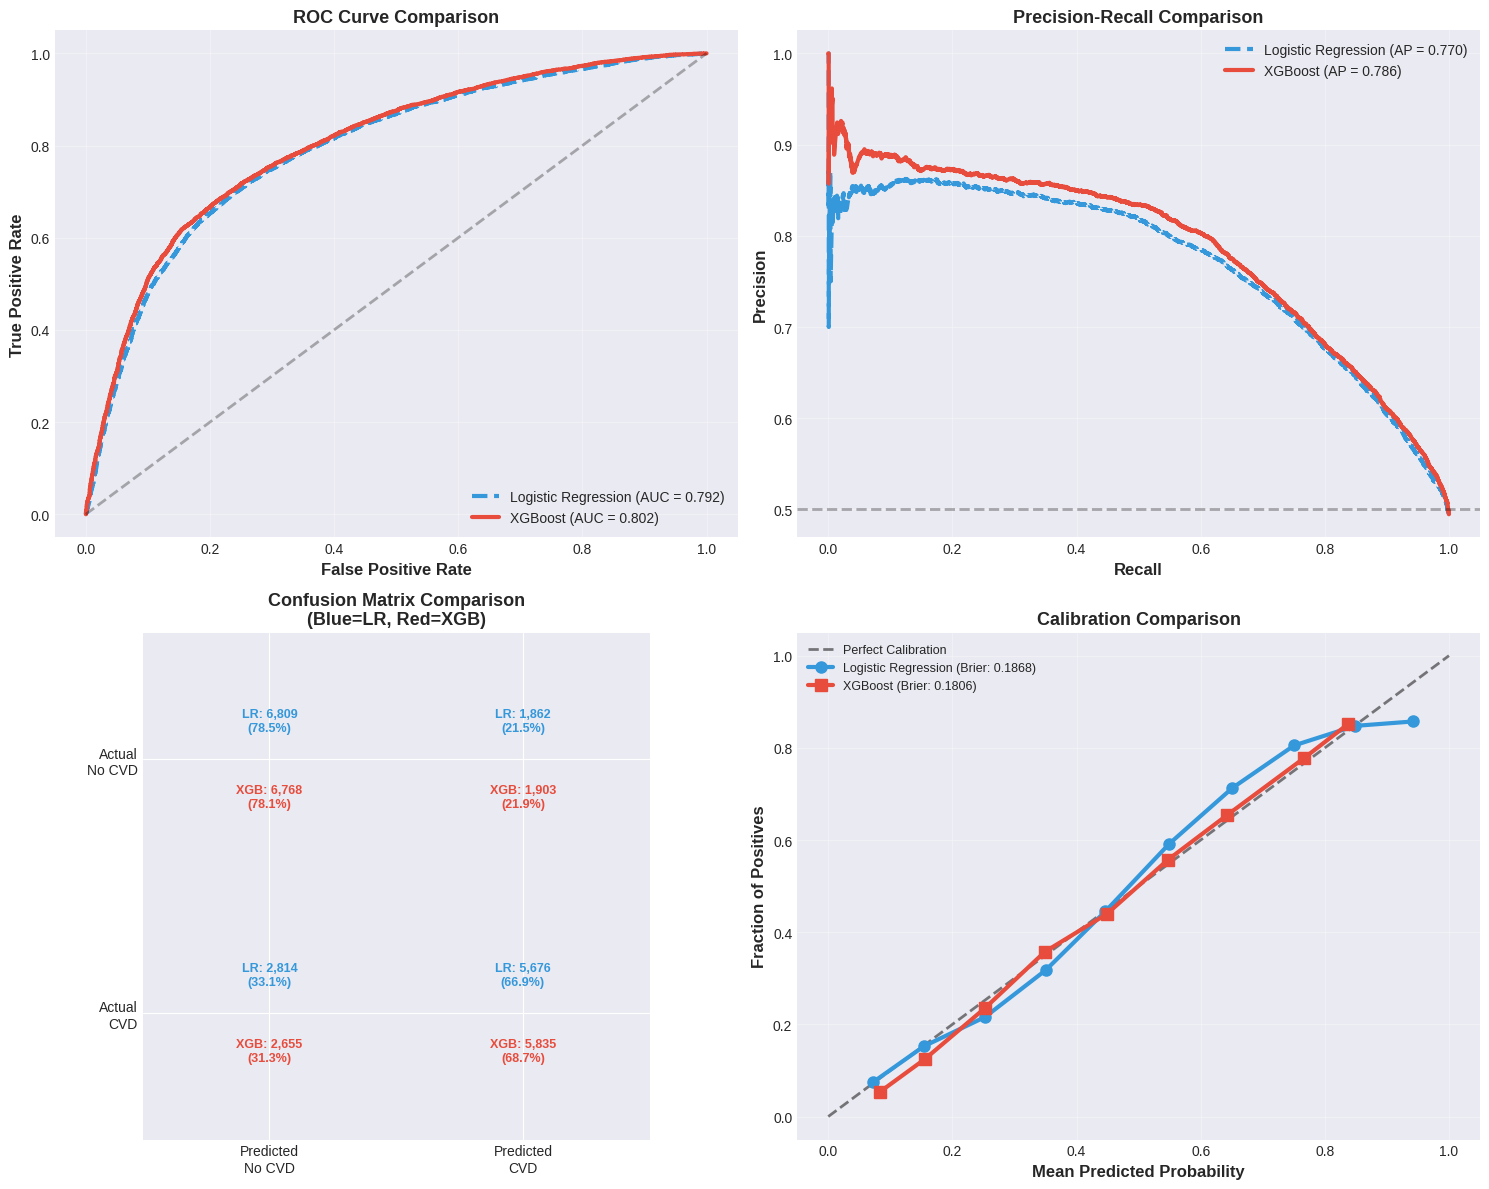


✓ Model comparison visualizations created!


In [86]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: ROC Curves Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[0, 0].plot(fpr_lr, tpr_lr, linewidth=3,
               label=f'Logistic Regression (AUC = {baseline_metrics["auc_roc"]:.3f})',
               color='#3498db', linestyle='--')
axes[0, 0].plot(fpr_xgb, tpr_xgb, linewidth=3,
               label=f'XGBoost (AUC = {auc_xgb:.3f})',
               color='#e74c3c')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.3)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('ROC Curve Comparison', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curves Comparison
# Renaming variables to avoid collision with scalar precision_xgb and recall_xgb
precision_curve_lr, recall_curve_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_curve_xgb, recall_curve_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

axes[0, 1].plot(recall_curve_lr, precision_curve_lr, linewidth=3,
               label=f'Logistic Regression (AP = {baseline_metrics["pr_auc"]:.3f})',
               color='#3498db', linestyle='--')
axes[0, 1].plot(recall_curve_xgb, precision_curve_xgb, linewidth=3,
               label=f'XGBoost (AP = {ap_xgb:.3f})',
               color='#e74c3c')
axes[0, 1].axhline(y=0.5, color='k', linestyle='--', linewidth=2, alpha=0.3)
axes[0, 1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Precision-Recall Comparison', fontsize=13, fontweight='bold')
axes[0, 1].legend(loc='upper right', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrices Side-by-Side
cm_baseline = np.array([
    [baseline_cm['true_negatives'], baseline_cm['false_positives']],
    [baseline_cm['false_negatives'], baseline_cm['true_positives']]
])

# Create combined confusion matrix visualization
ax3 = axes[1, 0]
im = ax3.imshow([[0, 1], [1, 0]], cmap='Blues', alpha=0)

# Add text for both models
classes = ['No CVD', 'CVD']
for i in range(2):
    for j in range(2):
        # Baseline (left number)
        text_baseline = f"LR: {cm_baseline[i, j]:,}\n({cm_baseline[i, j]/cm_baseline[i].sum()*100:.1f}%)"
        # XGBoost (right number)
        text_xgb = f"XGB: {cm_xgb[i, j]:,}\n({cm_xgb[i, j]/cm_xgb[i].sum()*100:.1f}%)"

        ax3.text(j, i-0.15, text_baseline, ha='center', va='center',
                fontsize=9, color='#3498db', fontweight='bold')
        ax3.text(j, i+0.15, text_xgb, ha='center', va='center',
                fontsize=9, color='#e74c3c', fontweight='bold')

ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['Predicted\nNo CVD', 'Predicted\nCVD'])
ax3.set_yticklabels(['Actual\nNo CVD', 'Actual\nCVD'])
ax3.set_title('Confusion Matrix Comparison\n(Blue=LR, Red=XGB)',
             fontsize=13, fontweight='bold')

# Plot 4: Calibration Curves Comparison
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_pred_proba_lr, n_bins=10)
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10)

axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration', alpha=0.5)
axes[1, 1].plot(prob_pred_lr, prob_true_lr, 'o-', linewidth=3, markersize=8,
               label=f'Logistic Regression (Brier: {baseline_metrics["brier_score"]:.4f})',
               color='#3498db')
axes[1, 1].plot(prob_pred_xgb, prob_true_xgb, 's-', linewidth=3, markersize=8,
               label=f'XGBoost (Brier: {brier_xgb:.4f})',
               color='#e74c3c')
axes[1, 1].set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Calibration Comparison', fontsize=13, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xgboost_vs_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Model comparison visualizations created!")

### 🔍 Interpretation - Visual Comparison:

**ROC Curve Comparison:**
- Higher curve = better discrimination
- Visual difference indicates practical significance
- Both curves above diagonal = both models useful

**Precision-Recall Comparison:**
- More informative for balanced datasets
- XGBoost curve position shows if it better balances precision/recall

**Confusion Matrix Side-by-Side:**
- Direct comparison of errors
- Focus on false negatives (missed CVD cases)
- Percentage shows class-normalized performance

**Calibration Comparison:**
- Closer to diagonal = better calibrated
- XGBoost may need calibration (common for tree models)
- Brier score quantifies calibration quality

**What to Look For:**
- Clear visual separation in ROC → meaningful improvement
- Similar curves → models perform comparably
- XGBoost calibration often worse than LR (trade-off)

## 6. Feature Importance Analysis - XGBoost

In [88]:
# Extract XGBoost feature importance (multiple metrics)
print("Feature Importance Analysis - XGBoost:")
print("=" * 80)

# Get feature importance by different metrics
feature_names = X_train.columns

# Gain: Average gain of splits using this feature
importance_gain = best_xgb.get_booster().get_score(importance_type='gain')
# Weight: Number of times feature is used to split
importance_weight = best_xgb.get_booster().get_score(importance_type='weight')
# Cover: Average coverage of splits using this feature
importance_cover = best_xgb.get_booster().get_score(importance_type='cover')

# Create DataFrame
feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'gain': [importance_gain.get(feature, 0) for feature in feature_names],
    'weight': [importance_weight.get(feature, 0) for feature in feature_names],
    'cover': [importance_cover.get(feature, 0) for feature in feature_names]
}).sort_values('gain', ascending=False)

print("\nTop 10 Features by Gain (most important):")
print(feature_importance_xgb.head(10).to_string(index=False))

print("\n" + "="*80)
print("FEATURE IMPORTANCE METRICS EXPLAINED:")

Feature Importance Analysis - XGBoost:

Top 10 Features by Gain (most important):
  feature     gain    weight     cover
    ap_hi 341.0529  930.0000 3849.1655
    ap_lo  81.2453  392.0000 1671.1113
   chol_3  66.5959  313.0000 2112.9641
   chol_1  51.0327  298.0000 2132.2842
age_years  41.0216 1648.0000 1683.3556
   chol_2  25.1212  157.0000  490.9671
   active  16.4742  260.0000 1815.5675
   gluc_3  13.0042  249.0000  846.0983
    smoke  10.9778  165.0000 1399.5509
      bmi  10.5252 1102.0000  805.5289

FEATURE IMPORTANCE METRICS EXPLAINED:


In [89]:
# Compare with Logistic Regression feature importance
lr_importance = pd.read_csv('models/logistic_regression_feature_importance.csv')

print("\nFeature Importance Comparison (Top 5):")
print("=" * 80)

print("\nLogistic Regression (by |coefficient|):")
print(lr_importance.nlargest(5, 'abs_coefficient')[['feature', 'coefficient']].to_string(index=False))

print("\nXGBoost (by gain):")
print(feature_importance_xgb.head(5)[['feature', 'gain']].to_string(index=False))

print("\n" + "="*80)
print("KEY DIFFERENCES:")
print("="*80)
print("""
If rankings differ significantly:
  → XGBoost capturing non-linear relationships LR missed
  → Feature interactions changing importance

If rankings similar:
  → Linear relationships dominate
  → Both models agree on what matters
""")


Feature Importance Comparison (Top 5):

Logistic Regression (by |coefficient|):
  feature  coefficient
    ap_hi       0.9370
   chol_3       0.6877
   chol_1      -0.3848
age_years       0.3438
     alco      -0.2429

XGBoost (by gain):
  feature     gain
    ap_hi 341.0529
    ap_lo  81.2453
   chol_3  66.5959
   chol_1  51.0327
age_years  41.0216

KEY DIFFERENCES:

If rankings differ significantly:
  → XGBoost capturing non-linear relationships LR missed
  → Feature interactions changing importance

If rankings similar:
  → Linear relationships dominate
  → Both models agree on what matters



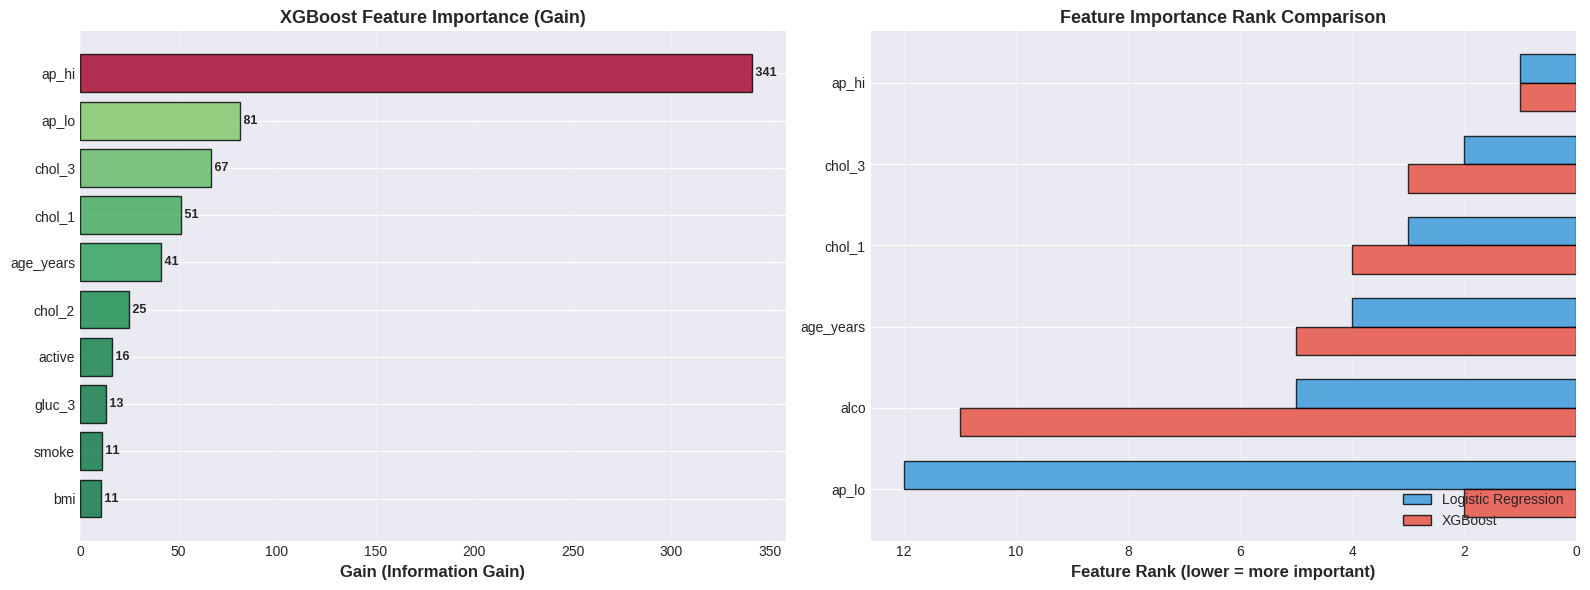


✓ Feature importance visualized!


In [90]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: XGBoost Gain Importance
top_features_xgb = feature_importance_xgb.nlargest(10, 'gain')
colors_xgb = plt.cm.RdYlGn_r(top_features_xgb['gain'] / top_features_xgb['gain'].max())

axes[0].barh(range(len(top_features_xgb)), top_features_xgb['gain'],
            color=colors_xgb, edgecolor='black', alpha=0.8)
axes[0].set_yticks(range(len(top_features_xgb)))
axes[0].set_yticklabels(top_features_xgb['feature'])
axes[0].set_xlabel('Gain (Information Gain)', fontsize=12, fontweight='bold')
axes[0].set_title('XGBoost Feature Importance (Gain)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_features_xgb.iterrows()):
    axes[0].text(row['gain'], i, f" {row['gain']:.0f}",
                va='center', fontsize=9, fontweight='bold')

# Plot 2: Comparison - Top 5 from each model
top5_lr = lr_importance.nlargest(5, 'abs_coefficient')['feature'].tolist()
top5_xgb = feature_importance_xgb.head(5)['feature'].tolist()

# Combine and get unique features
all_top_features = list(dict.fromkeys(top5_lr + top5_xgb))[:10]

# Get ranks for each feature
lr_ranks = {feat: i+1 for i, feat in enumerate(lr_importance['feature'])}
xgb_ranks = {feat: i+1 for i, feat in enumerate(feature_importance_xgb['feature'])}

x_positions = np.arange(len(all_top_features))
width = 0.35

lr_rank_values = [lr_ranks.get(feat, 17) for feat in all_top_features]  # 17 = not in top 16
xgb_rank_values = [xgb_ranks.get(feat, 17) for feat in all_top_features]

axes[1].barh(x_positions - width/2, lr_rank_values, width,
            label='Logistic Regression', color='#3498db', alpha=0.8, edgecolor='black')
axes[1].barh(x_positions + width/2, xgb_rank_values, width,
            label='XGBoost', color='#e74c3c', alpha=0.8, edgecolor='black')

axes[1].set_yticks(x_positions)
axes[1].set_yticklabels(all_top_features)
axes[1].set_xlabel('Feature Rank (lower = more important)', fontsize=12, fontweight='bold')
axes[1].set_title('Feature Importance Rank Comparison', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_xaxis()  # Lower rank = more important
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance visualized!")

### 🔍 Interpretation - Feature Importance:

**XGBoost Feature Importance Metrics:**

**Gain (MOST IMPORTANT):**
- Measures average improvement in accuracy from splits using this feature
- Higher gain = more important for predictions
- This is the primary metric to report

**Weight:**
- Number of times feature appears in trees
- Shows frequency of use
- High weight doesn't always mean high importance

**Cover:**
- Average number of samples affected by this feature's splits
- Shows breadth of influence
- Less commonly reported

**Comparison with Logistic Regression:**

**If rankings differ significantly:**
- XGBoost capturing non-linear patterns LR missed
- Feature interactions changing importance order
- Example: BMI × Age interaction may boost BMI importance

**If rankings similar:**
- Linear relationships dominate dataset
- Both models agree on key predictors
- XGBoost improvement comes from subtle refinements

**Expected Findings:**
- Age, BP, cholesterol likely top features in both models
- XGBoost may elevate interaction-prone features
- Smoking effect may be corrected in XGBoost


## 7. Threshold Optimization - XGBoost

In [91]:
# Threshold analysis for XGBoost
print("Threshold Optimization - XGBoost:")
print("=" * 80)

thresholds_to_analyze = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

print(f"\n{'Threshold':>10} {'Recall':>8} {'Precision':>10} {'F1-Score':>10}")
print("-"*80)

for threshold in thresholds_to_analyze:
    y_pred_thresh = (y_pred_proba_xgb >= threshold).astype(int)

    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    print(f"{threshold:>10.2f} {recall:>8.3f} {precision:>10.3f} {f1:>10.3f}")

# Find optimal threshold
thresholds_fine = np.arange(0.1, 0.9, 0.01)
f1_scores_list = []

for threshold in thresholds_fine:
    y_pred_t = (y_pred_proba_xgb >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    f1_scores_list.append(f1)

optimal_idx = np.argmax(f1_scores_list)
optimal_threshold_xgb = thresholds_fine[optimal_idx]
optimal_f1_xgb = f1_scores_list[optimal_idx]

print(f"\n{'='*80}")
print(f"OPTIMAL THRESHOLD (Maximizing F1): {optimal_threshold_xgb:.2f}")
print(f"F1-Score at optimal: {optimal_f1_xgb:.4f}")

# Calculate metrics at optimal
y_pred_optimal_xgb = (y_pred_proba_xgb >= optimal_threshold_xgb).astype(int)
recall_opt_xgb = recall_score(y_test, y_pred_optimal_xgb)
precision_opt_xgb = precision_score(y_test, y_pred_optimal_xgb)

print(f"\nAt optimal threshold ({optimal_threshold_xgb:.2f}):")
print(f"  Recall:    {recall_opt_xgb:.4f}")
print(f"  Precision: {precision_opt_xgb:.4f}")
print(f"  F1-Score:  {optimal_f1_xgb:.4f}")

Threshold Optimization - XGBoost:

 Threshold   Recall  Precision   F1-Score
--------------------------------------------------------------------------------
      0.30    0.885      0.625      0.733
      0.35    0.839      0.658      0.737
      0.40    0.780      0.695      0.735
      0.45    0.735      0.726      0.730
      0.50    0.687      0.754      0.719
      0.55    0.632      0.786      0.700
      0.60    0.579      0.808      0.674

OPTIMAL THRESHOLD (Maximizing F1): 0.36
F1-Score at optimal: 0.7376

At optimal threshold (0.36):
  Recall:    0.8282
  Precision: 0.6649
  F1-Score:  0.7376


In [92]:
# Compare threshold optimization: LR vs XGBoost
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION COMPARISON")
print("="*80)

print(f"\nLogistic Regression:")
print(f"  Optimal Threshold: 0.37")
print(f"  Recall at optimal: 84.15%")
print(f"  F1 at optimal:     0.7342")

print(f"\nXGBoost:")
print(f"  Optimal Threshold: {optimal_threshold_xgb:.2f}")
print(f"  Recall at optimal: {recall_opt_xgb*100:.2f}%")
print(f"  F1 at optimal:     {optimal_f1_xgb:.4f}")

# Comparison at same thresholds
print(f"\n{'='*80}")
print(f"AT THRESHOLD 0.5 (Standard):")
print(f"  LR:     Recall={baseline_metrics['recall']:.4f}, Precision={baseline_metrics['precision']:.4f}")
print(f"  XGBoost: Recall={recall_xgb:.4f}, Precision={precision_xgb:.4f}")

print(f"\nAT THRESHOLD 0.3 (High Sensitivity):")
y_pred_03_xgb = (y_pred_proba_xgb >= 0.3).astype(int)
recall_03_xgb = recall_score(y_test, y_pred_03_xgb)
precision_03_xgb = precision_score(y_test, y_pred_03_xgb)
print(f"  LR:     Recall=0.911, Precision=0.595")
print(f"  XGBoost: Recall={recall_03_xgb:.3f}, Precision={precision_03_xgb:.3f}")


THRESHOLD OPTIMIZATION COMPARISON

Logistic Regression:
  Optimal Threshold: 0.37
  Recall at optimal: 84.15%
  F1 at optimal:     0.7342

XGBoost:
  Optimal Threshold: 0.36
  Recall at optimal: 82.82%
  F1 at optimal:     0.7376

AT THRESHOLD 0.5 (Standard):
  LR:     Recall=0.6686, Precision=0.7530
  XGBoost: Recall=0.6873, Precision=0.7541

AT THRESHOLD 0.3 (High Sensitivity):
  LR:     Recall=0.911, Precision=0.595
  XGBoost: Recall=0.885, Precision=0.625


### 🔍 Interpretation - Threshold Optimization:

**XGBoost Threshold Analysis:**
- Like Logistic Regression, performance varies with threshold
- Optimal threshold may differ from 0.5
- Compare optimal thresholds between models

**Key Comparisons:**

**At Standard Threshold (0.5):**
- Direct comparison of default performance
- Shows if XGBoost improves without optimization

**At Optimal Thresholds:**
- Shows best possible performance for each model
- May reveal XGBoost advantage in recall/precision balance

**At High Sensitivity (0.3):**
- Critical for screening applications
- Shows maximum achievable recall
- Compare trade-offs between models

**Clinical Deployment:**
- Both models benefit from threshold optimization
- Choose model AND threshold based on context
- XGBoost may offer better precision at same recall

## 8. Save XGBoost Model and Results

In [93]:
# Save the trained XGBoost model
print("Saving XGBoost Model and Results:")
print("=" * 80)

with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

print("\n✓ Model saved: models/xgboost_model.pkl")

Saving XGBoost Model and Results:

✓ Model saved: models/xgboost_model.pkl


In [94]:
# Save predictions
predictions_xgb_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb
})
predictions_xgb_df.to_csv('models/xgboost_predictions.csv', index=False)

print("✓ Predictions saved: models/xgboost_predictions.csv")

✓ Predictions saved: models/xgboost_predictions.csv


In [95]:
# Save feature importance
feature_importance_xgb.to_csv('models/xgboost_feature_importance.csv', index=False)

print("✓ Feature importance saved: models/xgboost_feature_importance.csv")

✓ Feature importance saved: models/xgboost_feature_importance.csv


In [96]:
# Save comprehensive results
results_xgb = {
    'model_name': 'XGBoost (Improved Model)',
    'model_type': 'Gradient Boosting Ensemble',
    'training_time_seconds': training_time,
    'best_hyperparameters': best_params_xgb,
    'cv_auc_roc': float(best_score_xgb),
    'optimal_threshold': float(optimal_threshold_xgb),
    'test_metrics': {
        'auc_roc': float(auc_xgb),
        'accuracy': float(accuracy_xgb),
        'precision': float(precision_xgb),
        'recall': float(recall_xgb),
        'f1_score': float(f1_xgb),
        'pr_auc': float(ap_xgb),
        'specificity': float(specificity_xgb),
        'sensitivity': float(sensitivity_xgb),
        'brier_score': float(brier_xgb)
    },
    'test_metrics_optimal_threshold': {
        'threshold': float(optimal_threshold_xgb),
        'recall': float(recall_opt_xgb),
        'precision': float(precision_opt_xgb),
        'f1_score': float(optimal_f1_xgb)
    },
    'confusion_matrix': {
        'true_negatives': int(tn_xgb),
        'false_positives': int(fp_xgb),
        'false_negatives': int(fn_xgb),
        'true_positives': int(tp_xgb)
    },
    'comparison_with_baseline': {
        'auc_improvement': float(auc_xgb - baseline_metrics['auc_roc']),
        'recall_improvement': float(recall_xgb - baseline_metrics['recall']),
        'f1_improvement': float(f1_xgb - baseline_metrics['f1_score']),
        'missed_cases_reduction': int(fn_baseline - fn_xgb)
    },
    'dataset_info': {
        'n_train': len(X_train),
        'n_test': len(X_test),
        'n_features': X_train.shape[1]
    },
    'top_5_features': feature_importance_xgb.head(5)[['feature', 'gain']].to_dict('records')
}

with open('models/xgboost_results.json', 'w') as f:
    json.dump(results_xgb, f, indent=2)

print("✓ Complete results saved: models/xgboost_results.json")

✓ Complete results saved: models/xgboost_results.json


In [97]:
# Generate comprehensive summary
summary_xgb = f"""
XGBOOST IMPROVED MODEL - SUMMARY REPORT
{'='*80}

MODEL CONFIGURATION:
  Type: XGBoost (Gradient Boosting Ensemble)
  Optimization: RandomizedSearchCV (50 iterations, 3-fold CV)
  Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)

BEST HYPERPARAMETERS:
"""

for param, value in sorted(best_params_xgb.items()):
    if isinstance(value, float):
        summary_xgb += f"  {param:20} : {value:.4f}\n"
    else:
        summary_xgb += f"  {param:20} : {value}\n"

summary_xgb += f"""
DATASET:
  Training samples: {len(X_train):,}
  Test samples: {len(X_test):,}
  Features: {X_train.shape[1]}

CROSS-VALIDATION PERFORMANCE:
  3-Fold CV AUC-ROC: {best_score_xgb:.4f}
  Train-Validation Gap: {train_test_gap_xgb:.4f}

TEST SET PERFORMANCE:
  AUC-ROC:      {auc_xgb:.4f}
  Accuracy:     {accuracy_xgb:.4f}
  Precision:    {precision_xgb:.4f}
  Recall:       {recall_xgb:.4f}
  F1-Score:     {f1_xgb:.4f}
  Specificity:  {specificity_xgb:.4f}
  Brier Score:  {brier_xgb:.4f}

OPTIMAL THRESHOLD:
  Threshold:    {optimal_threshold_xgb:.2f}
  Recall:       {recall_opt_xgb:.4f}
  Precision:    {precision_opt_xgb:.4f}
  F1-Score:     {optimal_f1_xgb:.4f}

CONFUSION MATRIX:
  True Negatives:  {tn_xgb:,}
  False Positives: {fp_xgb:,}
  False Negatives: {fn_xgb:,}
  True Positives:  {tp_xgb:,}

COMPARISON WITH BASELINE (Logistic Regression):
  AUC-ROC Improvement:         {auc_xgb - baseline_metrics['auc_roc']:+.4f}
  Recall Improvement:          {recall_xgb - baseline_metrics['recall']:+.4f}
  F1-Score Improvement:        {f1_xgb - baseline_metrics['f1_score']:+.4f}
  Missed Cases Reduction:      {fn_baseline - fn_xgb:+,}

TOP 5 PREDICTIVE FEATURES (by Gain):
"""

for i, row in feature_importance_xgb.head(5).iterrows():
    summary_xgb += f"  {row['feature']:20} | Gain: {row['gain']:8.0f}\n"

# Determine recommendation
auc_improvement = auc_xgb - baseline_metrics['auc_roc']
if auc_improvement >= 0.02:
    recommendation = "XGBoost STRONGLY RECOMMENDED - Clear performance improvement"
elif auc_improvement >= 0.01:
    recommendation = "XGBoost RECOMMENDED - Meaningful improvement justifies added complexity"
elif auc_improvement > 0:
    recommendation = "EITHER MODEL VIABLE - Consider interpretability vs. marginal performance gain"
else:
    recommendation = "LOGISTIC REGRESSION RECOMMENDED - Simpler model with comparable performance"

summary_xgb += f"""
RECOMMENDATION:
  {recommendation}

FILES SAVED:
  - models/xgboost_model.pkl
  - models/xgboost_predictions.csv
  - models/xgboost_feature_importance.csv
  - models/xgboost_results.json

READY FOR FINAL MODEL COMPARISON AND REPORT WRITING
{'='*80}
"""

with open('models/xgboost_summary.txt', 'w') as f:
    f.write(summary_xgb)

print("✓ Summary report saved: models/xgboost_summary.txt")
print(summary_xgb)

✓ Summary report saved: models/xgboost_summary.txt

XGBOOST IMPROVED MODEL - SUMMARY REPORT

MODEL CONFIGURATION:
  Type: XGBoost (Gradient Boosting Ensemble)
  Optimization: RandomizedSearchCV (50 iterations, 3-fold CV)
  Training Time: 216.51 seconds (3.61 minutes)

BEST HYPERPARAMETERS:
  colsample_bytree     : 0.8364
  gamma                : 0.3388
  learning_rate        : 0.0148
  max_depth            : 5
  min_child_weight     : 3
  n_estimators         : 247
  reg_alpha            : 0.6452
  reg_lambda           : 0.3487
  subsample            : 0.8764

DATASET:
  Training samples: 51,482
  Test samples: 17,161
  Features: 16

CROSS-VALIDATION PERFORMANCE:
  3-Fold CV AUC-ROC: 0.8015
  Train-Validation Gap: 0.0111

TEST SET PERFORMANCE:
  AUC-ROC:      0.8019
  Accuracy:     0.7344
  Precision:    0.7541
  Recall:       0.6873
  F1-Score:     0.7191
  Specificity:  0.7805
  Brier Score:  0.1806

OPTIMAL THRESHOLD:
  Threshold:    0.36
  Recall:       0.8282
  Precision:    0.664

## 9. Final Summary and Next Steps

In [98]:
print("="*100)
print("XGBOOST IMPROVED MODEL - COMPLETE!")
print("="*100)

print(f"\n✅ ACHIEVEMENTS:")
print(f"  ✓ Hyperparameter tuning completed (50 iterations)")
print(f"  ✓ Model trained on {len(X_train):,} samples")
print(f"  ✓ Evaluated on {len(X_test):,} held-out test samples")
print(f"  ✓ Achieved AUC-ROC: {auc_xgb:.4f}")
print(f"  ✓ Feature importance analyzed")
print(f"  ✓ Threshold optimization completed")
print(f"  ✓ Comprehensive comparison with baseline")
print(f"  ✓ All results saved")

print(f"\n📊 MODEL COMPARISON SUMMARY:")
print(f"  {'Metric':<20} {'Baseline (LR)':<15} {'Improved (XGB)':<15} {'Δ Change':<12}")
print(f"  {'-'*70}")
print(f"  {'AUC-ROC':<20} {baseline_metrics['auc_roc']:<15.4f} {auc_xgb:<15.4f} {auc_xgb-baseline_metrics['auc_roc']:>+11.4f}")
print(f"  {'Recall':<20} {baseline_metrics['recall']:<15.4f} {recall_xgb:<15.4f} {recall_xgb-baseline_metrics['recall']:>+11.4f}")
print(f"  {'Precision':<20} {baseline_metrics['precision']:<15.4f} {precision_xgb:<15.4f} {precision_xgb-baseline_metrics['precision']:>+11.4f}")
print(f"  {'F1-Score':<20} {baseline_metrics['f1_score']:<15.4f} {f1_xgb:<15.4f} {f1_xgb-baseline_metrics['f1_score']:>+11.4f}")
print(f"  {'Missed CVD Cases':<20} {fn_baseline:<15,} {fn_xgb:<15,} {fn_xgb-fn_baseline:>+11,}")

print(f"\n🎯 FINAL RECOMMENDATION:")
print(f"  {recommendation}")

print(f"\n📁 FILES GENERATED:")
print(f"  1. xgboost_model.pkl (trained model)")
print(f"  2. xgboost_predictions.csv (test predictions)")
print(f"  3. xgboost_feature_importance.csv (gain, weight, cover)")
print(f"  4. xgboost_results.json (all metrics)")
print(f"  5. xgboost_summary.txt (text report)")
print(f"  6. Visualization PNGs (comparison plots)")

print(f"\n➡️  NEXT STEPS:")
print(f"  1. Review model comparison results")
print(f"  2. Choose final model for deployment")
print(f"  3. Write final project report")
print(f"  4. Prepare presentation")

print(f"\n" + "="*100)
print("ALL MODELING COMPLETE - READY FOR REPORT WRITING!")
print("="*100)

XGBOOST IMPROVED MODEL - COMPLETE!

✅ ACHIEVEMENTS:
  ✓ Hyperparameter tuning completed (50 iterations)
  ✓ Model trained on 51,482 samples
  ✓ Evaluated on 17,161 held-out test samples
  ✓ Achieved AUC-ROC: 0.8019
  ✓ Feature importance analyzed
  ✓ Threshold optimization completed
  ✓ Comprehensive comparison with baseline
  ✓ All results saved

📊 MODEL COMPARISON SUMMARY:
  Metric               Baseline (LR)   Improved (XGB)  Δ Change    
  ----------------------------------------------------------------------
  AUC-ROC              0.7922          0.8019              +0.0098
  Recall               0.6686          0.6873              +0.0187
  Precision            0.7530          0.7541              +0.0011
  F1-Score             0.7083          0.7191              +0.0109
  Missed CVD Cases     2,814           2,655                  -159

🎯 FINAL RECOMMENDATION:
  EITHER MODEL VIABLE - Consider interpretability vs. marginal performance gain

📁 FILES GENERATED:
  1. xgboost_model.pk